# The Adam Algorithm for Optimization

### Abstract

In this blog post, I explore ADAM, an optimization algorithm that is the backbone of deep learning. It is a stochastic objective function with first-order gradient-based optimization. It is computationally efficient, has little memory requirements, and is suitable for classification task that involves large number of features and parameters. I will compare ADAM gradient descent with the classic stochastic gradient descent in this blog post. 

In [47]:
import torch
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Basic Experiments

First, we want to generate data for the basic classification problem. Similar to my previous Logistic Regression post, here is a function that would help us to generate data of two classes. We can determine the noise of the data, which represents to what extent these two classes of data are mixed together. Here, I am creating a two dimensional experimental data with noise equals to 0.3. 

In [48]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y
torch.manual_seed(123989)
X, y = classification_data(noise = 0.3)

Here is how the data looks like when displayed on a coordinate system. 

Text(0.5, 1.0, 'Distribution of Experimental Data')

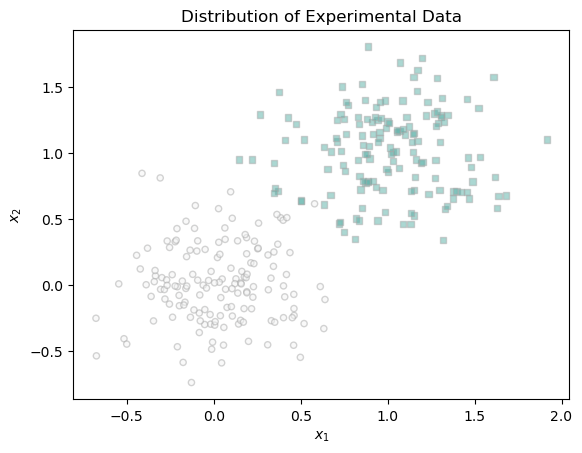

In [49]:
from matplotlib import pyplot as plt
def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
plot_data(X, y, ax)
ax.set_title("Distribution of Experimental Data")

Now, we start implementing ADAM. The object-oriented paradigm of the logistic regression could be seen here [adam.py](adam.py). The script corresponds to the comments in Alg. 1 of Kingma and Ba's (2017) work. 

In [50]:
from adam import LogisticRegression, AdamOptimizer

#initiate logistic regression and optimization function
LR = LogisticRegression() 
ADAM = AdamOptimizer(LR)

# keep track of loss values
loss_vec_1 = []

# specify batch size
batch_size = 60

for _ in range(2000):
    
    # choose a random batch of indices
    i = torch.randint(0, X.shape[0], (batch_size,))
    
    ADAM.step(X[i], y[i], alpha = 0.006, beta1 = 0.9, beta2 = 0.9)

    loss = LR.loss(X[i], y[i]) 
    loss_vec_1.append(loss)
    if loss == 0:
        break

In [52]:
from logistic import LogisticRegression, GradientDescentOptimizer
LR_SGD = LogisticRegression()
opt = GradientDescentOptimizer(LR_SGD)

# keep track of loss values
loss_vec_2 = []

# specify batch size
batch_size = 60

for _ in range(2000):
    
    # choose a random batch of indices
    i = torch.randint(0, X.shape[0], (batch_size,))
    
    opt.step(X[i], y[i], alpha = 0.006, beta = 0.0)

    loss = LR_SGD.loss(X[i], y[i]) 
    loss_vec_2.append(loss)

    if loss == 0:
        break

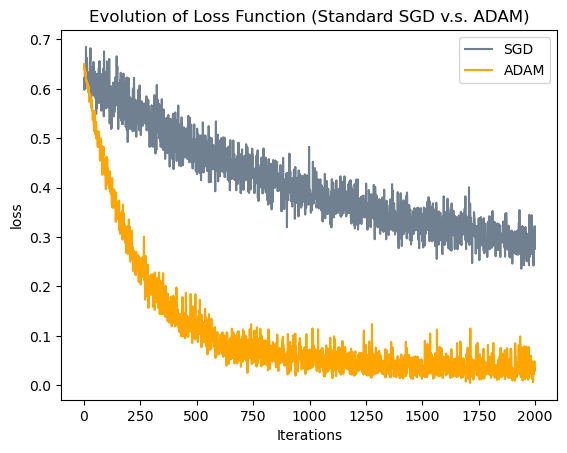

In [54]:
plt.plot(loss_vec_2, color = "slategrey", label = "SGD")
plt.plot(loss_vec_1, color = "orange", label = "ADAM")
labs = plt.gca().set(xlabel = "Iterations", ylabel = "loss")
plt.title("Evolution of Loss Function (Standard SGD v.s. ADAM)")
plt.legend()

It took both ADAM and SGD 0.7 second to finish 2000 iterations. Compare the evolutions of two algorithms' loss functions, we find that ADAM flattens earlier than SGD. In fact, SGD has not yet converged at its 2000 iteration. The magnitude of oscillation for ADAM is smaller than that of SGD. 

# Perform a Digit Experiment

Next, we are going to compare the performance of Stochastic Gradient Descent and ADAM using the Digit dataset from `scikit-learn`. First, we select two classes from the dataset and seperate the explanatory and target variables. 

In [30]:
from sklearn import datasets
import numpy as np
import torch

# Load the digits dataset
digits = datasets.load_digits(n_class=2)

# Extract features (X) and target (y)
X1 = digits.data.astype(np.double)
y1 = digits.target.astype(np.double)

X = torch.Tensor(X1)
y = torch.Tensor(y1)

X = X.double()
y = y.double()



The dataset has double as datatype, but our `logistic.py` and `adam.py` only accept float values. Hence, I create new python scripts `logisticDouble.py` and `adam.py` that could accomodate this datatype difference. Now, we implement the both of the alogorith. 

In [31]:
from adamDouble import LogisticRegression, AdamOptimizer

torch.manual_seed(997)
#initiate logistic regression and optimization function for ADAM
LR = LogisticRegression() 
ADAM = AdamOptimizer(LR)

# keep track of loss values for ADAM
loss_vec_3 = []

# specify batch size
batch_size = 30

for _ in range(800):
    
    # choose a random batch of indices
    i = torch.randint(0, X.shape[0], (batch_size,))
    
    g = ADAM.step(X[i], y[i], alpha = 0.01, beta1 = 0.9, beta2 = 0.99)
    loss_vec_3.append(g)



In [32]:
from logisticDouble import LogisticRegression, GradientDescentOptimizer

torch.manual_seed(47)
#initiate logistic regression and optimization function for Stochastic Gradient Descent Logistic Regression
LR_SGD = LogisticRegression()
opt = GradientDescentOptimizer(LR_SGD)

# keep track of loss values
loss_vec_4 = []

# specify batch size
batch_size = 30

for _ in range(800):
    
    # choose a random batch of indices
    i = torch.randint(0, X.shape[0], (batch_size,))
    
    opt.step(X[i], y[i], alpha = 0.01)

    loss = LR_SGD.loss(X[i], y[i]) 
    loss_vec_4.append(loss)


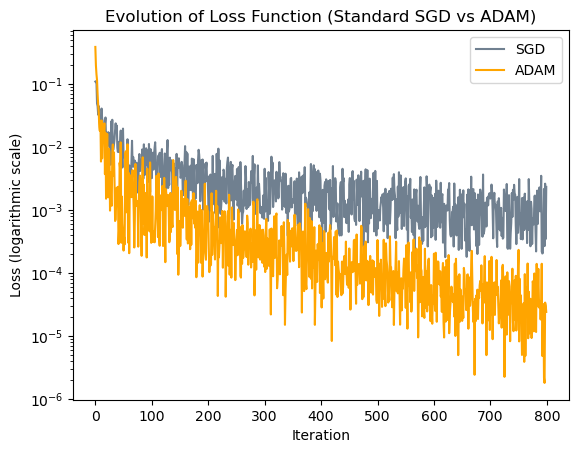

In [43]:
plt.plot(loss_vec_4, color = "slategrey", label = "SGD")
plt.plot(loss_vec_3, color = "orange", label = "ADAM")
plt.yscale('log')

plt.xlabel("Iteration")
plt.ylabel("Loss (logarithmic scale)")

plt.title("Evolution of Loss Function (Standard SGD vs ADAM)")
plt.legend()

From the graph above, though ADAM starts from a higher loss, it converges faster than the standard stochastic gradient descent regression in the first 100 iteration and its loss function also flattens at a lower loss value. 

### Explore my own dataset

I found a interesting dataset on Kaggle that record the living environment of different types of crops. Here, I will use two types of logistic regression algorithm to classify two types of crops: 'Rice' and 'Lentil'. First, we read the dataset, select rows that are rice and lentil, and then separate the explanatory and target variables. 

In [34]:
# Import dataset of crop recommendation
import pandas as pd
crop = pd.read_csv("Crop_Recommendation.csv")
crop = crop[crop['Crop'].isin(['Rice', 'Lentil'])]
# let 'rice' be 0 and 'Lentil' be 1.
crop['Crop'].replace(['Rice', 'Lentil'],[0, 1], inplace=True)
crop

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,0
1,85,58,41,21.770462,80.319644,7.038096,226.655537,0
2,60,55,44,23.004459,82.320763,7.840207,263.964248,0
3,74,35,40,26.491096,80.158363,6.980401,242.864034,0
4,78,42,42,20.130175,81.604873,7.628473,262.717340,0
...,...,...,...,...,...,...,...,...
895,26,56,22,23.052764,60.424786,7.011121,52.602853,1
896,9,77,17,21.658458,63.583371,6.280726,38.076594,1
897,4,59,19,26.250703,67.627797,7.621495,40.810630,1
898,34,73,15,20.971953,63.831799,7.630424,53.102079,1


In [35]:
X_crop = torch.tensor(crop.iloc[:, :7].values)
y_crop = torch.tensor(crop.iloc[:, 7].values)

Now, we implement both algorithms and make graph comparing their performance. 

In [44]:
from logisticDouble import LogisticRegression, GradientDescentOptimizer

torch.manual_seed(47)
LR_SGD = LogisticRegression()
opt = GradientDescentOptimizer(LR_SGD)

# keep track of loss values
loss_vec_5 = []

# specify batch size
batch_size = 30

for _ in range(500):
    # choose a random batch of indices
    i = torch.randint(0, X_crop.shape[0], (batch_size,))
    loss = opt.step(X_crop[i], y_crop[i], alpha = 0.001)
    loss_vec_5.append(loss)

In [45]:
from adamDouble import LogisticRegression, AdamOptimizer

torch.manual_seed(47)
LR = LogisticRegression() 
ADAM = AdamOptimizer(LR)

# keep track of loss values
loss_vec_6 = []

# specify batch size
batch_size = 30

for _ in range(500):
    
    # choose a random batch of indices
    i = torch.randint(0, X_crop.shape[0], (batch_size,))
    
    loss = ADAM.step(X_crop[i], y_crop[i], alpha = 0.001, beta1 = 0.9, beta2 = 0.99)
    loss_vec_6.append(loss)

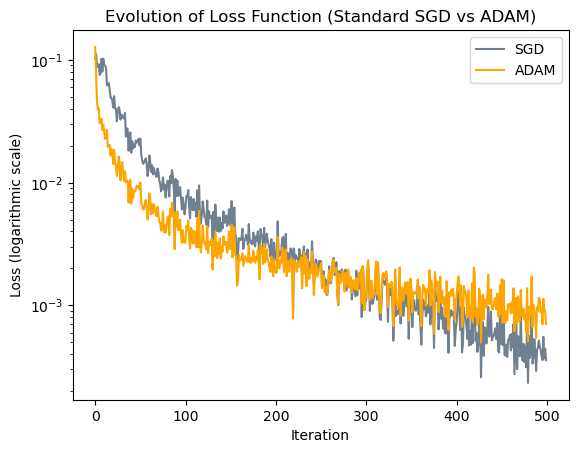

In [55]:

plt.plot(loss_vec_6, color = "slategrey", label = "SGD")
plt.plot(loss_vec_5, color = "orange", label = "ADAM")
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Loss (logarithmic scale)")

plt.title("Evolution of Loss Function (Standard SGD vs ADAM)")
plt.legend()

The plot shows similar result with the digit dataset. ADAM apparently descents at a higher rate than SGD. However, it appears that ADAM converges at a higher loss value than SGD at its 500 iteration. 

### Conclusion


Using ADAM helps the logistic regression algorithm to converge more efficiently. Different from previous logistic regression algorithms we have implemented, ADAM updates both exponential moving averages of the gradient $m_t$ and the squared gradient $v_t$. They estimate of the 1st moment (the mean) and the 2nd raw moment (the uncentered variance) of the gradient. Through bias correction mechanism, ADAM's avoids initialization bias toward zero. Additionally, ADAM chooses its stepsize carefully when updating. Adam adapts the learning rates for each parameter individually based on the estimates of the first and second moments of the gradients. This adaptiveness allows Adam to converge quickly. From my experiment, ADAM does show advantage in converging at a faster speed in terms of iteration. The run time when implementing ADAM is larger than that when implementing SGD, and I suppose it is due to the computation complexity of ADAM when handling two gradient during one update. 